## Testing all available models to see which gives the best accuracy, speed and which models work in europe

This Jupyter Notebook systematically evaluates various Google Gemini models across specified Google Cloud Platform (GCP) regions. Its primary goal is to assess model availability and performance specifically for image analysis tasks relevant to this hackathon project.

The notebook iterates through a predefined list of Gemini models (e.g., `gemini-2.0-flash-001`, `gemini-1.5-pro-001`) and GCP regions (`us-central1`, `europe-west1`, etc.). For each image file found in the `inputs/` directory, it attempts an API call using a basic descriptive prompt to the designated model within the selected region.

Key metrics recorded include:
* API call success/failure status.
* Average processing time per image (in milliseconds) for successful calls.
* Any errors encountered during initialization or processing.

The results are presented in two ways:
1.  A **summary table** (using Pandas) for easy comparison of model availability and speed across different regions.
2.  A **bar chart** (using Matplotlib) visualizing the average processing times for available model/region combinations.

Additionally, the raw text outputs generated by successful model analyses are saved to `outputs/model_test_outputs.json`. This allows for manual review and qualitative assessment of the output precision and relevance for the project's specific needs.

This entire process facilitates the selection of the most suitable *accessible* model and region combination based on empirical performance data and manual quality evaluation.


### All the imports

In [8]:
import os
import time
import logging
import json
from typing import List, Dict, Any
import sys
import traceback

# Project Path Setup
project_root = os.path.abspath('.')  # Assumes notebook is in root
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Library Imports
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import vertexai
    from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image as VertexImage
    from google.api_core import exceptions as google_exceptions
    print("Libraries imported successfully.")
except ImportError as e:
    print(f"Error: Missing libraries. Run 'pip install -r requirements.txt'. Details: {e}")
    raise

# Project Modules
try:
    import config
    try:
        import utils
        print("Utils module loaded.")
    except ImportError:
        print("Utils module not found. Continuing without it.")
        utils = None
    print(f"Config loaded. Project ID: {config.GCP_PROJECT_ID}, Region: {config.GCP_REGION}")
except Exception as e:
    print(f"Error loading config/utils: {e}")
    raise

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("google.api_core").setLevel(logging.WARNING)
logging.getLogger("google.auth").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)


Libraries imported successfully.
Utils module loaded.
Config loaded. Project ID: maximal-cider-458611-r5, Region: europe-west1


#### Okay after some testing I have come to realise europe-west2 and europe-west3 wont work for my region

### Test Execution & Table Output 

In [13]:
# Define Models and Regions to test (Refined based on availability)
MODELS_TO_TEST = [
    "gemini-2.0-flash-001",      # Current Gen, should be available in some EU regions
    "gemini-2.0-flash-lite-001", # Lighter version, check availability
    # Add other models here ONLY if confirmed available in target regions
    # Avoid deprecated 1.x models unless specifically needed for comparison
    # Avoid 2.5 previews unless using the global endpoint or confirmed region availability
]

REGIONS_TO_TEST = [
    "us-central1",    # Baseline
    "europe-west1",   # Belgium (Should support gemini-2.0-flash-001)
    "europe-west4",   # Netherlands (Should support gemini-2.0-flash-001)
    # Add other relevant EU regions if needed and model availability is confirmed
    # Removed europe-west2, europe-west3 as gemini-2.0-flash-001 wasn't listed there
]

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}
TEST_PROMPT = "Describe this image briefly, focusing on any text present."
DETAILED_OUTPUT_FILENAME = "model_test_outputs.json"

# === Helper Functions ===

def get_image_files(input_dir: str) -> List[str]:
    """Gets a list of absolute paths for image files in the input directory."""
    files = []
    if not os.path.isdir(input_dir):
        logging.error(f"Directory not found: {input_dir}")
        return files
    for fname in os.listdir(input_dir):
        if fname.startswith('.'): continue # Skip hidden files
        fpath = os.path.join(input_dir, fname)
        if os.path.isfile(fpath) and os.path.splitext(fname.lower())[1] in IMAGE_EXTENSIONS:
            files.append(os.path.abspath(fpath))
    logging.info(f"Found {len(files)} image files in {input_dir}")
    return files

# === Helper Function (Modified for better error detail) ===
def test_model_in_region(project_id: str, region: str, model_id: str, image_paths: List[str]) -> Dict[str, Any]:
    """Tests a single model in a specific region with multiple images."""
    results = {
        "model": model_id,
        "region": region,
        "status": "Unknown",
        "avg_time_ms": None, # Initialize avg_time_ms
        "times_ms": [],
        "errors": [],
        "outputs": {} # Store successful outputs {image_filename: text_output}
    }
    model = None
    initialization_error = None

    logging.info(f"--- Testing: Initializing Vertex AI for {project_id} in {region} ---")
    try:
        # Ensure vertexai is imported (should be from first cell)
        vertexai.init(project=project_id, location=region)
        logging.info(f"Vertex AI Initialized for region {region}")
        logging.info(f"Instantiating model: {model_id}")
        # Ensure GenerativeModel is imported (should be from first cell)
        model = GenerativeModel(model_id)
        logging.info(f"Model {model_id} instantiated.")
        results["status"] = "Initialized"
    except google_exceptions.NotFound as e:
        logging.error(f"Initialization failed: Model {model_id} not found in {region}. Details: {e}")
        initialization_error = f"Model Not Found in {region}"
        results["status"] = "Model Not Found"
        results["errors"] = [initialization_error]
        return results # Cannot proceed if model not found
    except Exception as e:
        logging.error(f"Initialization failed for {model_id} in {region}: {e}", exc_info=True)
        initialization_error = f"Initialization Error: {type(e).__name__}"
        results["status"] = "Initialization Error"
        results["errors"] = [initialization_error]
        return results # Cannot proceed if init fails

    if not model: # Should not happen if logic above is correct, but safeguard
         results["status"] = "Failed to Initialize (Unknown)"
         results["errors"] = ["Model object is None after initialization block."]
         return results

    start_time_total = time.time()

    for img_path in image_paths:
        img_filename = os.path.basename(img_path)
        logging.info(f"Processing image: {img_filename} with {model_id} in {region}")
        individual_start_time = time.time()
        try:
            # Ensure VertexImage is imported (should be from first cell)
            vertex_image = VertexImage.load_from_file(img_path)
            content = [vertex_image, TEST_PROMPT]
            response = model.generate_content(content, stream=False)

            # --- Check response before accessing .text ---
            if not response.candidates or not response.candidates[0].content.parts:
                 finish_reason = "UNKNOWN"
                 feedback_str = "N/A"
                 if hasattr(response, 'candidates') and response.candidates:
                     finish_reason = response.candidates[0].finish_reason.name
                 if hasattr(response, 'prompt_feedback'):
                    feedback_str = str(response.prompt_feedback) # Convert feedback object to string
                 error_msg = f"Processing Error ({img_filename}): No content generated. Finish Reason: {finish_reason}. Feedback: {feedback_str}"
                 logging.error(error_msg)
                 results["errors"].append(f"{img_filename}: No Content ({finish_reason})")
                 continue

            # --- Try accessing response text ---
            try:
                generated_text = response.text
                individual_end_time = time.time()
                elapsed_ms = (individual_end_time - individual_start_time) * 1000
                results["times_ms"].append(elapsed_ms)
                results["outputs"][img_filename] = generated_text
            except AttributeError:
                 finish_reason = "UNKNOWN"
                 if hasattr(response, 'candidates') and response.candidates:
                     finish_reason = response.candidates[0].finish_reason.name
                 logging.error(f"AttributeError accessing .text for {img_filename}. Finish Reason: {finish_reason}. Raw parts: {response.candidates[0].content.parts if response.candidates else 'N/A'}", exc_info=False)
                 results["errors"].append(f"{img_filename}: Processing Error (AttributeError on .text, FinishReason: {finish_reason})")
            except Exception as inner_e:
                 logging.error(f"Unexpected error processing response for {img_filename}: {inner_e}", exc_info=True)
                 results["errors"].append(f"{img_filename}: Processing Error (Inner Exception: {type(inner_e).__name__})")

        # --- Specific API Error Handling ---
        except google_exceptions.NotFound as e:
            error_msg = f"Model Not Found error during generate_content for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Model Not Found Error")
            results["status"] = "Model Not Found"
            break # Stop testing this combo
        except google_exceptions.ResourceExhausted as e:
            error_msg = f"Resource Exhausted error during generate_content for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Resource Exhausted Error")
            results["status"] = "Resource Exhausted"
            break # Stop testing this combo
        except google_exceptions.InvalidArgument as e:
            error_msg = f"Invalid Argument error during generate_content for {img_filename}: {e}"
            logging.error(error_msg)
            results["errors"].append(f"{img_filename}: Invalid Argument Error")
            # Continue unless persistent
        except Exception as e:
            error_msg = f"Generic processing error for {img_filename}: {e}"
            logging.error(error_msg, exc_info=True)
            results["errors"].append(f"{img_filename}: Processing Error ({type(e).__name__})")
            # Continue

    end_time_total = time.time()
    logging.info(f"Finished processing images for {model_id} in {region}. Total time: {end_time_total - start_time_total:.2f}s")

    # --- Final status determination ---
    if results["status"] not in ["Model Not Found", "Resource Exhausted", "Initialization Error", "Failed to Initialize (Unknown)"]:
        if not results["times_ms"]:
             # Consolidate error messages if possible
             unique_errors = list(set(err.split(':')[1].strip() if ':' in err else err for err in results["errors"]))
             if len(unique_errors) == 1:
                 results["status"] = f"Processing Errors ({unique_errors[0]})"
             else:
                 results["status"] = "Processing Errors"
        elif len(results["times_ms"]) < len(image_paths):
             results["status"] = "Partial Success"
             results["avg_time_ms"] = sum(results["times_ms"]) / len(results["times_ms"]) # Avg of successful ones
        else:
            results["status"] = "Available"
            results["avg_time_ms"] = sum(results["times_ms"]) / len(results["times_ms"])

    # Ensure avg_time_ms is None (or NaN for Pandas) if not available
    if results["status"] != "Available" and results["status"] != "Partial Success":
         results["avg_time_ms"] = None # Use None for clarity before DataFrame conversion

    return results

# === Execute Model Tests and Print Summary Table ===

# Ensure config module is loaded (should be from first cell)
image_files_to_test = get_image_files(config.INPUT_DIR)
if not image_files_to_test:
    raise FileNotFoundError(f"No images found in {config.INPUT_DIR}. Please add images to the 'inputs' directory.")

all_test_results_list = []
detailed_outputs_dict = {}
original_region = config.GCP_REGION # Store original region from config

# Ensure pandas and time are imported (should be from first cell)
for region in REGIONS_TO_TEST:
    for model_id in MODELS_TO_TEST:
        print(f"\n>>> Testing Model: {model_id} in Region: {region} <<<")
        # Make sure required variables (project_id) are available from config
        result_data = test_model_in_region(
            project_id=config.GCP_PROJECT_ID,
            region=region,
            model_id=model_id,
            image_paths=image_files_to_test
        )
        # Format errors for display - keep only unique error messages per file
        error_summary = "None"
        if result_data["errors"]:
             unique_file_errors = {}
             for error_str in result_data["errors"]:
                 parts = error_str.split(':', 1)
                 file_part = parts[0].strip()
                 msg_part = parts[1].strip() if len(parts) > 1 else "Unknown Error Detail"
                 if file_part not in unique_file_errors:
                     unique_file_errors[file_part] = set()
                 unique_file_errors[file_part].add(msg_part)
             # Create a summarized string
             error_list_str = [f"{fname}: {', '.join(sorted(msgs))}" for fname, msgs in unique_file_errors.items()]
             error_summary = "; ".join(error_list_str)
             # Limit length for display if needed
             if len(error_summary) > 150: # Example limit
                 error_summary = error_summary[:147] + "..."

        all_test_results_list.append({
            "Model": result_data["model"],
            "Region": result_data["region"],
            "Status": result_data["status"],
            # Use result_data['avg_time_ms'] which might be None
            "Avg Time (ms)": result_data["avg_time_ms"],
            "Errors": error_summary
        })
        # Store detailed outputs only if fully available
        if result_data["status"] == "Available":
            key = f"{region}_{model_id}"
            detailed_outputs_dict[key] = result_data["outputs"]
        time.sleep(2) # Be nice to the API

# Re-initialize to original region (optional, good practice)
try:
    if original_region and original_region != vertexai.initializer.global_config.location:
        logging.info(f"Restoring Vertex AI to original region: {original_region}")
        vertexai.init(project=config.GCP_PROJECT_ID, location=original_region)
except Exception as e:
    logging.warning(f"Failed to restore region to {original_region}: {e}")

# Save detailed outputs to JSON
# Ensure os and json are imported (should be from first cell)
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
output_json_path = os.path.join(config.OUTPUT_DIR, DETAILED_OUTPUT_FILENAME)
try:
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(detailed_outputs_dict, f, indent=4, ensure_ascii=False)
    logging.info(f"Detailed outputs saved to {output_json_path}")
except Exception as e:
    logging.error(f"Failed to save detailed outputs to {output_json_path}: {e}")


# === Print Summary Table ===
# Ensure pandas (pd) and display are available (should be from first cell)
summary_df = pd.DataFrame(all_test_results_list)
# Convert None in 'Avg Time (ms)' to NaN for Pandas operations if needed, then format
summary_df['Avg Time (ms)'] = pd.to_numeric(summary_df['Avg Time (ms)'], errors='coerce')
summary_df_display = summary_df.copy()
# Format for display AFTER potential calculations
summary_df_display["Avg Time (ms)"] = summary_df_display["Avg Time (ms)"].apply(
    lambda x: f"{x:.0f}" if pd.notnull(x) else "N/A"
)
# Optional: Set display options for wider columns if errors get truncated
# pd.set_option('display.max_colwidth', None) # Uncomment to see full errors if needed

print("\n--- Test Summary ---")
display(summary_df_display)

2025-05-02 21:16:28,312 - INFO - Found 7 image files in /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs
2025-05-02 21:16:28,313 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-02 21:16:28,314 - INFO - Vertex AI Initialized for region us-central1
2025-05-02 21:16:28,314 - INFO - Instantiating model: gemini-2.0-flash-001
2025-05-02 21:16:28,314 - INFO - Model gemini-2.0-flash-001 instantiated.
2025-05-02 21:16:28,314 - INFO - Processing image: 1.jpeg with gemini-2.0-flash-001 in us-central1



>>> Testing Model: gemini-2.0-flash-001 in Region: us-central1 <<<


2025-05-02 21:16:38,474 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:42,094 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:44,893 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:47,380 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:50,545 - INFO - Processing image: test.jpg with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:53,258 - INFO - Processing image: test.png with gemini-2.0-flash-001 in us-central1
2025-05-02 21:16:59,785 - INFO - Finished processing images for gemini-2.0-flash-001 in us-central1. Total time: 31.47s
2025-05-02 21:17:01,789 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in us-central1 ---
2025-05-02 21:17:01,790 - INFO - Vertex AI Initialized for region us-central1
2025-05-02 21:17:01,791 - INFO - Instantiating model: gemini-2.0-flash-lite-001
2025-05-


>>> Testing Model: gemini-2.0-flash-lite-001 in Region: us-central1 <<<


2025-05-02 21:17:05,022 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:07,620 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:09,700 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:12,433 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:15,267 - INFO - Processing image: test.jpg with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:17,773 - INFO - Processing image: test.png with gemini-2.0-flash-lite-001 in us-central1
2025-05-02 21:17:19,318 - INFO - Finished processing images for gemini-2.0-flash-lite-001 in us-central1. Total time: 17.52s
2025-05-02 21:17:21,321 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-02 21:17:21,323 - INFO - Vertex AI Initialized for region europe-west1
2025-05-02 21:17:21,323 - INFO - Instantiating mode


>>> Testing Model: gemini-2.0-flash-001 in Region: europe-west1 <<<


2025-05-02 21:17:23,433 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:25,802 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:27,469 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:29,487 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:31,425 - INFO - Processing image: test.jpg with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:33,457 - INFO - Processing image: test.png with gemini-2.0-flash-001 in europe-west1
2025-05-02 21:17:34,408 - INFO - Finished processing images for gemini-2.0-flash-001 in europe-west1. Total time: 13.08s
2025-05-02 21:17:36,411 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west1 ---
2025-05-02 21:17:36,413 - INFO - Vertex AI Initialized for region europe-west1
2025-05-02 21:17:36,414 - INFO - Instantiating model: gemini-2.0-flash-lite-001


>>> Testing Model: gemini-2.0-flash-lite-001 in Region: europe-west1 <<<


2025-05-02 21:17:38,831 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:40,795 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:43,657 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:45,041 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:46,892 - INFO - Processing image: test.jpg with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:48,837 - INFO - Processing image: test.png with gemini-2.0-flash-lite-001 in europe-west1
2025-05-02 21:17:49,829 - INFO - Finished processing images for gemini-2.0-flash-lite-001 in europe-west1. Total time: 13.41s
2025-05-02 21:17:51,833 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west4 ---
2025-05-02 21:17:51,834 - INFO - Vertex AI Initialized for region europe-west4
2025-05-02 21:17:51,835 - INFO - Instantiati


>>> Testing Model: gemini-2.0-flash-001 in Region: europe-west4 <<<


2025-05-02 21:17:54,063 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:17:56,001 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:17:57,786 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:17:59,599 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:18:02,045 - INFO - Processing image: test.jpg with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:18:03,699 - INFO - Processing image: test.png with gemini-2.0-flash-001 in europe-west4
2025-05-02 21:18:04,649 - INFO - Finished processing images for gemini-2.0-flash-001 in europe-west4. Total time: 12.81s
2025-05-02 21:18:06,652 - INFO - --- Testing: Initializing Vertex AI for maximal-cider-458611-r5 in europe-west4 ---
2025-05-02 21:18:06,653 - INFO - Vertex AI Initialized for region europe-west4
2025-05-02 21:18:06,654 - INFO - Instantiating model: gemini-2.0-flash-lite-001


>>> Testing Model: gemini-2.0-flash-lite-001 in Region: europe-west4 <<<


2025-05-02 21:18:08,391 - INFO - Processing image: 2.jpeg with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:09,951 - INFO - Processing image: 3.jpeg with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:11,774 - INFO - Processing image: 4.jpeg with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:13,129 - INFO - Processing image: 5.jpeg with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:15,284 - INFO - Processing image: test.jpg with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:17,189 - INFO - Processing image: test.png with gemini-2.0-flash-lite-001 in europe-west4
2025-05-02 21:18:18,355 - INFO - Finished processing images for gemini-2.0-flash-lite-001 in europe-west4. Total time: 11.70s
2025-05-02 21:18:20,358 - WARNING - Failed to restore region to europe-west1: module 'vertexai' has no attribute 'initializer'
2025-05-02 21:18:20,360 - INFO - Detailed outputs saved to /home/harishi/common_drive/Downloads/projects/GDG_HACK


--- Test Summary ---


,Model,Region,Status,Avg Time (ms),Errors
0,gemini-2.0-flash-001,us-central1,Available,4495,None
1,gemini-2.0-flash-lite-001,us-central1,Available,2502,None
2,gemini-2.0-flash-001,europe-west1,Available,1868,None
3,gemini-2.0-flash-lite-001,europe-west1,Available,1915,None
4,gemini-2.0-flash-001,europe-west4,Available,1829,None
5,gemini-2.0-flash-lite-001,europe-west4,Available,1670,None


### Graph Rendering

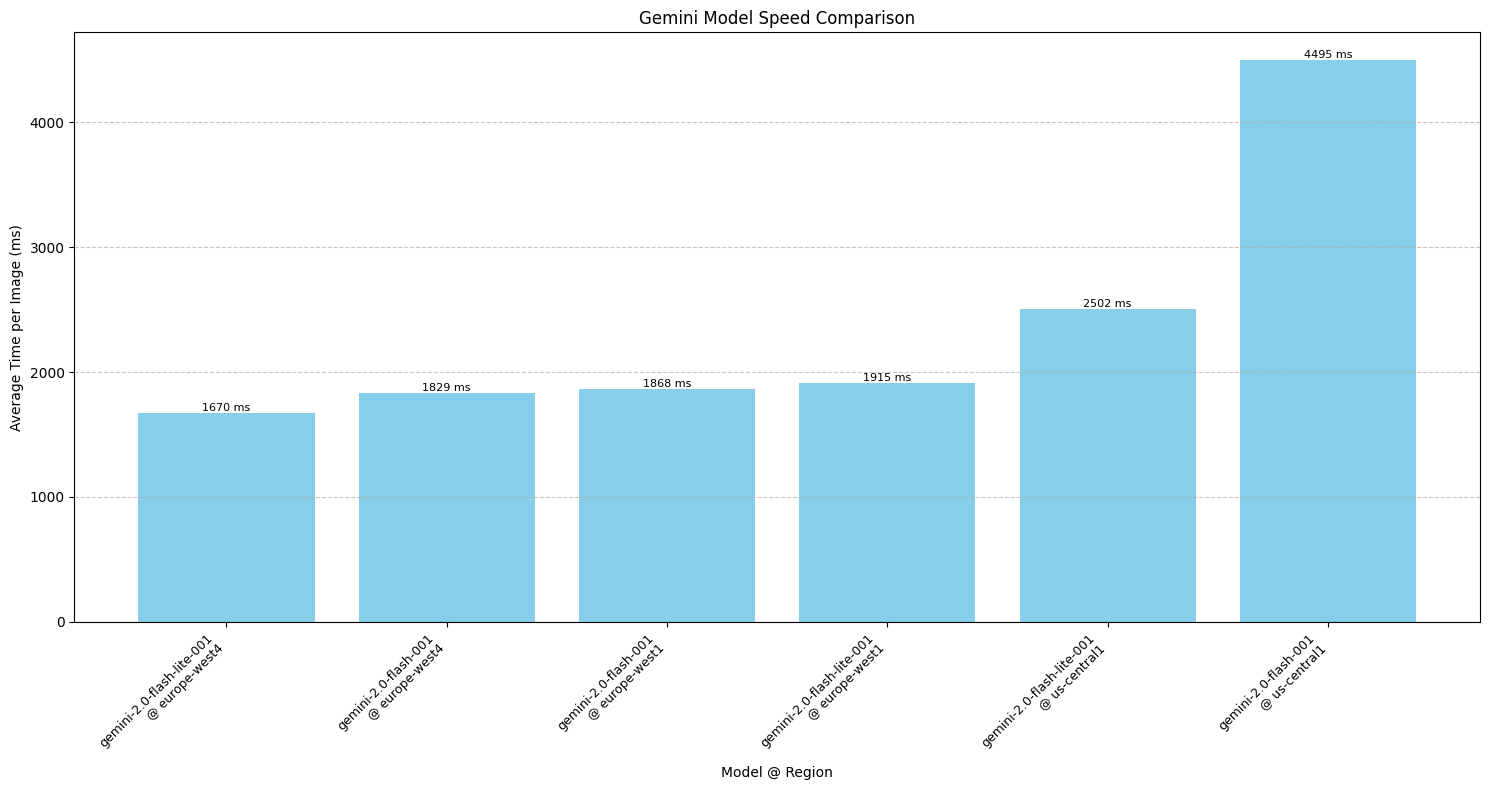

In [14]:
available_df = summary_df[
    (summary_df['Status'] == 'Available') & pd.notnull(summary_df['Avg Time (ms)'])
].copy()

if not available_df.empty:
    available_df['Label'] = available_df['Model'] + '\n@ ' + available_df['Region']
    available_df.sort_values('Avg Time (ms)', inplace=True)

    plt.figure(figsize=(15, 8))
    bars = plt.bar(available_df['Label'], available_df['Avg Time (ms)'], color='skyblue')

    plt.xlabel("Model @ Region")
    plt.ylabel("Average Time per Image (ms)")
    plt.title("Gemini Model Speed Comparison")
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f} ms', va='bottom', ha='center', fontsize=8)

    plt.show()
else:
    print("No data available for graph.")


### Final Verdict

Based on the results from this test run:

* The combination of model `gemini-2.0-flash-lite-001` in region `europe-west4` appears to be the fastest *available* option among those successfully tested.

* For a qualitative review of the text outputs generated by the successful model/region combinations, refer to the `outputs/model_test_outputs.json` file.